In [559]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plts

In [560]:
reference_data_new = pd.read_csv("data/raw_aact/combined_neuro_trials_with_interventions_20240313.csv")

# Load annotated data

In [1097]:
data_path = Path("data/annotated_aact/")


In [1098]:
df_annotations_all = pd.read_csv(data_path/ "ner_outputs/aggregated_ner_annotations_basic_dict_mapped_19632.csv")
df_annotations_all.shape

(19632, 8)

In [1099]:
df_annotations_all.head(2)

,Unnamed: 0,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class
0,0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases
1,1,NCT00000146,corticosteroid,prednisone|methylprednisolone,Drug,multiple sclerosis|optic neuritis,optic neuritis|multiple sclerosis,Demyelinating Diseases|Cranial Nerve Diseases


In [1100]:
model_prefix = "combined"
entity_types = ["conditions", "interventions"]
if model_prefix == "linkbert":
    mapped_size = [18212, 16917]
elif model_prefix == "aact":
    mapped_size = [19632, 18720]
else:
    mapped_size = [19632, 19632]

In [1101]:
# Loop through each entity type, read the corresponding file, and perform the join
for entity_type, mapped_nr in zip(entity_types, mapped_size):
    # Construct the file path
    file_path = data_path / f"snomed_linking_outputs/mapped_to_hierarchy/hierarchical_mapping_to_snomed_{model_prefix}_{entity_type}_aggregated_{mapped_nr}.csv"
    
    # Read the data
    df_entity = pd.read_csv(file_path, index_col=0)
    
    # Perform the left join on nct_id
    df_annotations_all = df_annotations_all.merge(df_entity, on='nct_id', how='left')

if model_prefix == "combined":
    df_annotations_all[f'canonical_combined_{entity_type}'] = df_annotations_all[f'canonical_BioLinkBERT-base_{entity_type}'].combine_first(df_annotations_all[f'canonical_aact_{entity_type}'])


In [1102]:
df_annotations_all.shape

(19632, 21)

In [1103]:
df_annotations_all.head(2)

,Unnamed: 0,nct_id,canonical_BioLinkBERT-base_interventions,canonical_aact_interventions,aact_intervention_types,canonical_BioLinkBERT-base_conditions,canonical_aact_conditions,Disease Class,linkbert_snomed_term_canonical_conditions,linkbert_top_concept_canonical_first_conditions,...,aact_top_concept_canonical_first_conditions,combined_snomed_term_canonical_conditions,combined_top_concept_canonical_first_conditions,linkbert_snomed_term_canonical_interventions,linkbert_top_concept_canonical_first_interventions,aact_snomed_term_canonical_interventions,aact_top_concept_canonical_first_interventions,combined_snomed_term_canonical_interventions,combined_top_concept_canonical_first_interventions,canonical_combined_interventions
0,0,NCT00000117,intravenous immunoglobulin|ivig,immunoglobulin,Drug,multiple sclerosis|optic neuritis,optic neuritis,Cranial Nerve Diseases,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Disorder of opti...,...,Disorder of optic nerve (disorder),Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Disorder of opti...,Immunoglobulin (substance),Immunoglobulin (substance),Immunoglobulin (substance),Blood component (substance),Immunoglobulin (substance),Immunoglobulin (substance),intravenous immunoglobulin|ivig
1,1,NCT00000146,corticosteroid,prednisone|methylprednisolone,Drug,multiple sclerosis|optic neuritis,optic neuritis|multiple sclerosis,Demyelinating Diseases|Cranial Nerve Diseases,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Disorder of opti...,...,Disorder of optic nerve (disorder)|Multiple sc...,Multiple sclerosis (disorder)|Optic neuritis (...,Multiple sclerosis (disorder)|Disorder of opti...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...,Prednisone (substance)|Methylprednisolone (sub...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...,Corticosteroid and/or corticosteroid derivativ...,corticosteroid


### Prepare for analysis
NOTE: The reference that in this version contains only the neuro trials, which contained an intervention annotation from BioLinkBERT (DRUG) or AACT

#### decide with columns to plot

In [1104]:
evaluate_snomed_link = True
hierarchical_mapping_conditions = True
hierarchical_mapping_interventions = False

if  model_prefix == "linkbert":
    target_ner_column_prefix = 'canonical_BioLinkBERT-base'
elif model_prefix == "aact":
    target_ner_column_prefix = 'canonical_aact'
else:
    target_ner_column_prefix = 'canonical_combined'

if evaluate_snomed_link:
    if hierarchical_mapping_conditions and hierarchical_mapping_interventions:
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_hierarchical'
    elif hierarchical_mapping_conditions and (not hierarchical_mapping_interventions):
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_top_concept_canonical_first_conditions'
        annotations_type = f'{model_prefix}_sapbert_cond_hier'
    elif hierarchical_mapping_interventions and (not hierarchical_mapping_conditions):
        target_interventions_column = f'{model_prefix}_top_concept_canonical_first_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert_interv_hier'
    else:
        target_interventions_column = f'{model_prefix}_snomed_term_canonical_interventions'
        target_conditions_column = f'{model_prefix}_snomed_term_canonical_conditions'
        annotations_type = f'{model_prefix}_sapbert'
else:
    target_interventions_column = f'{target_ner_column_prefix}_interventions'
    target_conditions_column = f'{target_ner_column_prefix}_conditions'
    annotations_type = model_prefix


In [1105]:
annotations_type

'combined_sapbert_cond_hier'

#### select columns to plot and merge with metadata

In [1106]:
df_normalized_annotations = df_annotations_all[['nct_id', target_interventions_column, target_conditions_column]]
reference_data_with_target_annotations = df_normalized_annotations.merge(reference_data_new, on='nct_id', how='left')
reference_data_with_target_annotations.head(2)

,nct_id,combined_snomed_term_canonical_interventions,combined_top_concept_canonical_first_conditions,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type
0,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Disorder of opti...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug
1,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Disorder of opti...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug


In [1107]:
reference_data_with_target_annotations_to_save = reference_data_with_target_annotations[['nct_id','brief_title', 'Neurological Disease', 'Disease Class', 'brief_summary_description']]

In [1108]:
reference_data_with_target_annotations_to_save.head()

,nct_id,brief_title,Neurological Disease,Disease Class,brief_summary_description
0,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
1,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
2,NCT00000117,Intravenous Immunoglobulin Therapy in Optic Ne...,Optic Neuritis,Cranial Nerve Diseases,To determine whether high-dose intravenous imm...
3,NCT00000146,Optic Neuritis Treatment Trial (ONTT),Multiple Sclerosis,Demyelinating Diseases,To assess the beneficial and adverse effects o...
4,NCT00000146,Optic Neuritis Treatment Trial (ONTT),Multiple Sclerosis,Demyelinating Diseases,To assess the beneficial and adverse effects o...


In [1109]:
len(set(reference_data_with_target_annotations['nct_id'])), reference_data_with_target_annotations.shape

(19632, (262638, 16))

In [1110]:
reference_data_with_target_annotations.head(2)

,nct_id,combined_snomed_term_canonical_interventions,combined_top_concept_canonical_first_conditions,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_name,intervention_type
0,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Disorder of opti...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug
1,NCT00000117,Immunoglobulin (substance),Multiple sclerosis (disorder)|Disorder of opti...,Optic Neuritis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Immunoglobulin,Drug


#### explode to have single entity per row

In [1111]:
# replace the raw aact column with normalized columns
reference_data_with_target_annotations = reference_data_with_target_annotations.drop(columns=['Neurological Disease', 'intervention_name'])

reference_data_with_target_annotations[target_interventions_column] = reference_data_with_target_annotations[target_interventions_column].str.split('|')
reference_data_with_target_annotations[target_conditions_column] = reference_data_with_target_annotations[target_conditions_column].str.split('|')

# Exploding both columns to create new rows for each value
df_exploded_target_annotations = reference_data_with_target_annotations.explode(target_interventions_column)
df_exploded_target_annotations = df_exploded_target_annotations.explode(target_conditions_column)

# rename the target model columns to a standard column name
df_exploded_target_annotations.rename(columns={target_interventions_column: 'intervention_name'}, inplace=True)
df_exploded_target_annotations.rename(columns={target_conditions_column: 'Neurological Disease'}, inplace=True)

reference_data = df_exploded_target_annotations.copy()
# Convert 'start_date' and 'completion_date' to datetime
reference_data['start_date'] = pd.to_datetime(reference_data['start_date'])
reference_data['completion_date'] = pd.to_datetime(reference_data['completion_date'])

# Extract the year from 'start_date' and 'completion_date'
reference_data['start_year'] = reference_data['start_date'].dt.year
reference_data['completion_year'] = reference_data['completion_date'].dt.year

reference_data = reference_data[reference_data['start_year']<2024]

In [1112]:
# Function to format long intervention names with new line after every 4 words
def format_long_name(name, max_words=4):
    if isinstance(name, float):
        return ''  # Handle NaN values
    words = name.split()
    if len(words) > max_words:
        return '\n'.join([' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)])
    return name

# Apply the formatting function to the dataframe
reference_data['intervention_name'] = reference_data['intervention_name'].apply(format_long_name)
reference_data['Neurological Disease'] = reference_data['Neurological Disease'].apply(format_long_name)


In [1113]:
reference_data_with_entity_tags = reference_data.copy()

In [1114]:
# Function to remove (substance) and (disorder) suffixes
def remove_suffixes(text):
    if isinstance(text, str):
        text = text.replace('(substance)', '').replace('(disorder)', '').strip()
    return text

# Apply the function to the relevant columns
reference_data['intervention_name'] = reference_data['intervention_name'].apply(remove_suffixes)
reference_data['Neurological Disease'] = reference_data['Neurological Disease'].apply(remove_suffixes)


In [1115]:
reference_data.shape

(1427694, 16)

In [1058]:
reference_data.head(2)

,nct_id,intervention_name,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_type,start_year,completion_year
0,NCT00000117,Immunoglobulin,Multiple sclerosis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0
0,NCT00000117,Immunoglobulin,Disorder of optic nerve,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0


In [1059]:
len(set(df_normalized_annotations['nct_id'])), df_normalized_annotations.shape

(19632, (19632, 3))

In [1060]:
len(set(reference_data['nct_id']))

19060

# Diseases

In [1061]:
viz_path_diseases = Path("viz/conditions/")

In [1062]:
reference_data.head(5)

,nct_id,intervention_name,Neurological Disease,Disease Class,brief_title,study_official_title,brief_summary_description,start_date,completion_date,phase,study_type,overall_status,country_name,intervention_type,start_year,completion_year
0,NCT00000117,Immunoglobulin,Multiple sclerosis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0
0,NCT00000117,Immunoglobulin,Disorder of optic nerve,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0
1,NCT00000117,Immunoglobulin,Multiple sclerosis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0
1,NCT00000117,Immunoglobulin,Disorder of optic nerve,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0
2,NCT00000117,Immunoglobulin,Multiple sclerosis,Cranial Nerve Diseases,Intravenous Immunoglobulin Therapy in Optic Ne...,NaN,To determine whether high-dose intravenous imm...,1995-08-31,1997-12-31,Phase 3,Interventional,Completed,United States,Drug,1995.0,1997.0


In [1063]:
reference_data.columns

Index(['nct_id', 'intervention_name', 'Neurological Disease', 'Disease Class',
       'brief_title', 'study_official_title', 'brief_summary_description',
       'start_date', 'completion_date', 'phase', 'study_type',
       'overall_status', 'country_name', 'intervention_type', 'start_year',
       'completion_year'],
      dtype='object')

In [1064]:
aact_diseases = reference_data[['nct_id', 'Neurological Disease', 'Disease Class', 'phase', 'overall_status','start_year','completion_year']]

In [1065]:
aact_diseases[aact_diseases['Neurological Disease']=='Depression']

,nct_id,Neurological Disease,Disease Class,phase,overall_status,start_year,completion_year


In [1066]:
def plot_entity_frequency(data, entity_column, entity_type, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the frequency of entities (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id' and the specified entity column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """

    # Keeping only unique nct_id, entity pairs
    unique_pairs = data[['nct_id', entity_column]].drop_duplicates()

    # Counting the number of nct_ids per entity type
    entity_counts = unique_pairs[entity_column].value_counts()
    entity_counts = entity_counts.sort_values(ascending=True).tail(top_n)

    # Create a horizontal bar chart for the top N data types
    plt.figure(figsize=(10, 8))
    bars = plt.barh(entity_counts.index, entity_counts, color='lightgrey', zorder=2, height=0.7)  #)

    # Add labels to each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

    plt.tick_params(axis='y', labelsize=14)
    plt.tick_params(axis='x', labelsize=15)
    plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column.capitalize()} {annotations_type}', fontsize=15)
    plt.xlim(0, max(entity_counts) + max(entity_counts)/10)  # Adjusted to max count for relevancy
    plt.tight_layout()

    # Save the plot to the specified path
    plot_filename = viz_path / f'{entity_type}_frequency_{annotations_type}.png'
    plt.savefig(plot_filename)

    # Display the chart
    plt.show()


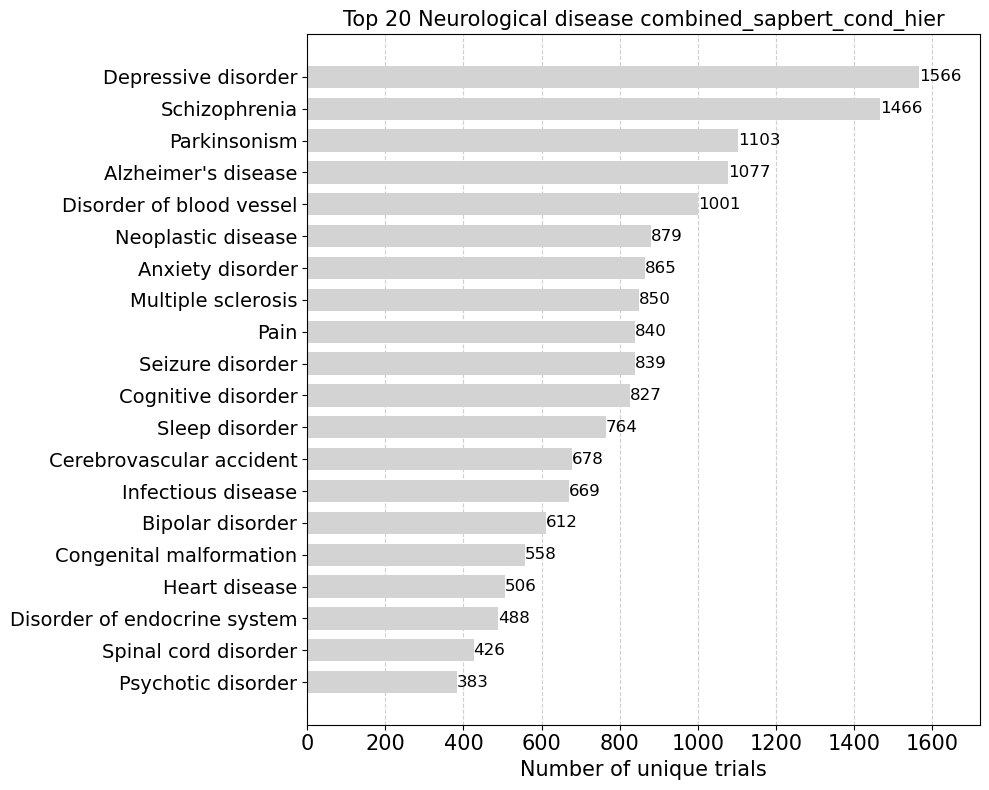

In [1067]:
plot_entity_frequency(aact_diseases, 'Neurological Disease', 'disease', annotations_type, viz_path_diseases, top_n=20)


## Disease/ All and Completed Trials

In [1068]:
# Step 1: Count total trials per disease
total_disease_counts = aact_diseases[['nct_id', 'Neurological Disease']].drop_duplicates()['Neurological Disease'].value_counts()

# Filter 'Completed' status and count completed trials per disease
completed_trials = aact_diseases[aact_diseases['overall_status'] == 'Completed']
completed_disease_counts = completed_trials[['nct_id', 'Neurological Disease']].drop_duplicates()['Neurological Disease'].value_counts()

# Calculate proportions of completed trials
completed_proportions = (completed_disease_counts / total_disease_counts).fillna(0) * 100  # Proportion in percentage

# Sorting to get top 20 diseases by total count
sorted_diseases = total_disease_counts.sort_values(ascending=True).tail(20)
sorted_completed_proportions = completed_proportions.reindex(index=sorted_diseases.index)
sorted_completed_proportions

Neurological Disease
Psychotic disorder              70.757180
Spinal cord disorder            56.572770
Disorder of endocrine system    57.786885
Heart disease                   48.814229
Congenital malformation         51.612903
Bipolar disorder                70.915033
Infectious disease              61.584454
Cerebrovascular accident        50.589971
Sleep disorder                  61.649215
Cognitive disorder              59.371221
Seizure disorder                66.388558
Pain                            56.309524
Multiple sclerosis              59.529412
Anxiety disorder                56.878613
Neoplastic disease              53.583618
Disorder of blood vessel        56.743257
Alzheimer's disease             61.931291
Parkinsonism                    63.372620
Schizophrenia                   72.100955
Depressive disorder             62.005109
Name: count, dtype: float64

In [1069]:
def plot_entity_trials(data, entity_column, entity_type, status_column, status_value, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the total and completed trials per entity (e.g., diseases, interventions) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing 'nct_id', the specified entity column, and the status column.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases, interventions).
    status_column (str): The column name representing the status of the trials.
    status_value (str): The value in the status column representing the completed status.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top items to display in the chart. Default is 20.
    """
    # Ensure viz_path is a Path object
    viz_path = Path(viz_path)

    # Step 1: Count total trials per entity, ensuring unique nct_id within each entity
    total_entity_counts = data[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Step 2: Filter completed status and count completed trials per entity, ensuring unique nct_id
    completed_trials = data[data[status_column] == status_value]
    completed_entity_counts = completed_trials[['nct_id', entity_column]].drop_duplicates()[entity_column].value_counts()

    # Sorting total_entity_counts in descending order to determine plot order and select top entities
    sorted_entities = total_entity_counts.sort_values(ascending=True).tail(top_n+1).index

    # Reindexing completed_entity_counts according to sorted_entities for alignment
    completed_entity_counts = completed_entity_counts.reindex(index=sorted_entities).fillna(0)

    # Step 3: Plot a horizontal bar chart
    plt.figure(figsize=(10, 7))

    # Plotting total trials
    bars_total = plt.barh(sorted_entities, total_entity_counts[sorted_entities], color='lightgrey', label='Total Trials')

    # Plotting completed trials
    bars_completed = plt.barh(sorted_entities, completed_entity_counts[sorted_entities], color='darkgrey', label='Completed Trials')

    #plt.ylabel(entity_column.capitalize(), fontsize=15)
    plt.xlabel('Number of unique trials', fontsize=15)
    plt.title(f'Top {top_n} {entity_column.capitalize()} with Completed Trials Count {annotations_type}', fontsize=16)
    plt.yticks(ticks=range(len(sorted_entities)), labels=sorted_entities)
    plt.legend()

    # Adding labels to the bars
    for bar in bars_total:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center', ha='left')

    for bar in bars_completed:
        width = bar.get_width()
        # Only label the bar if the width is significant to avoid clutter
        if width > 0:
            plt.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='right', color='white')

    plt.xlim(0, max(total_entity_counts) + 100)  # Adjusted to max count for relevancy
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_frequency_with_completed_{annotations_type}.png')

    plt.show()

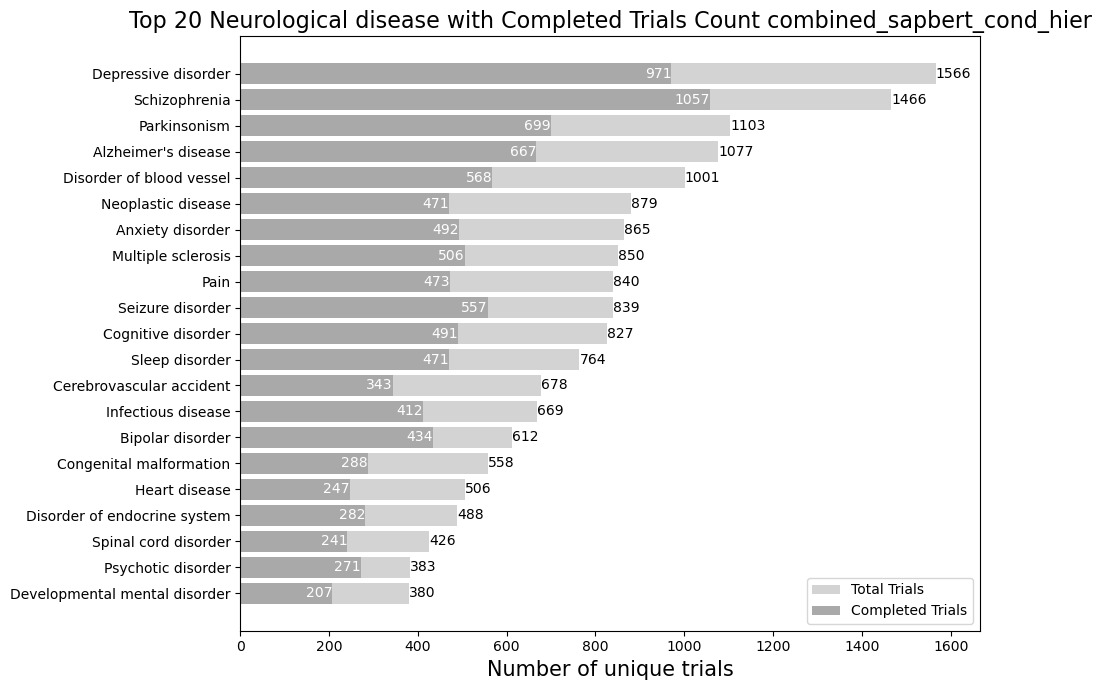

In [1070]:
plot_entity_trials(aact_diseases, 'Neurological Disease', 'disease', 'overall_status', 'Completed', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Phase

In [1071]:
# Aggregate trials by disease and phase, counting unique nct_ids
disease_phase_counts = aact_diseases.groupby(['Neurological Disease', 'phase'])['nct_id'].nunique().reset_index()

# Pivot the data to have diseases as rows and phases as columns, filling missing values with 0
pivot_df = disease_phase_counts.pivot(index='Neurological Disease', columns='phase', values='nct_id').fillna(0)

# Calculate total trials per disease to identify the top 20 diseases
pivot_df['Total Trials'] = pivot_df.sum(axis=1)
top_20_diseases = pivot_df.sort_values('Total Trials', ascending=False).head(21)
top_20_diseases

phase,Early Phase 1,Not Applicable,Phase 1,Phase 1/Phase 2,Phase 2,Phase 2/Phase 3,Phase 3,Phase 4,Total Trials
Neurological Disease,,,,,,,,,
Depressive disorder,43.0,356.0,131.0,43.0,302.0,50.0,239.0,402.0,1566.0
Schizophrenia,15.0,194.0,223.0,34.0,261.0,40.0,320.0,379.0,1466.0
Parkinsonism,21.0,117.0,221.0,64.0,329.0,38.0,167.0,146.0,1103.0
Alzheimer's disease,39.0,118.0,300.0,54.0,295.0,28.0,153.0,90.0,1077.0
Disorder of blood vessel,16.0,224.0,55.0,31.0,190.0,34.0,250.0,201.0,1001.0
Neoplastic disease,40.0,150.0,146.0,68.0,255.0,20.0,118.0,82.0,879.0
Anxiety disorder,24.0,200.0,46.0,25.0,241.0,43.0,112.0,174.0,865.0
Multiple sclerosis,14.0,80.0,115.0,60.0,203.0,28.0,198.0,152.0,850.0
Pain,19.0,247.0,35.0,23.0,176.0,34.0,136.0,170.0,840.0


In [1072]:
def plot_phase_distribution(data, entity_column, entity_type, phase_column, nct_id_column, annotations_type, viz_path, top_n=20):
    """
    Generates a horizontal bar chart for the phase distribution within top entities (e.g., diseases) 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, phase, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    phase_column (str): The column name representing the phases of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 20.
    """
    # Step 1: Count total trials per entity per phase
    entity_phase_counts = data.groupby([entity_column, phase_column])[nct_id_column].nunique().reset_index()
    
    # Step 2: Pivot the filtered data to have entities as rows and phases as columns, filling missing values with 0
    pivot_df_filtered = entity_phase_counts.pivot(index=entity_column, columns=phase_column, values=nct_id_column).fillna(0)
    
    # Step 3: Calculate total trials per entity to identify the top N entities
    pivot_df_filtered['Total Trials'] = pivot_df_filtered.sum(axis=1)
    top_entities_filtered = pivot_df_filtered.sort_values('Total Trials', ascending=False).head(top_n)
    
    # Step 4: Drop the 'Total Trials' column as it's no longer needed for plotting
    top_entities_filtered = top_entities_filtered.drop(columns='Total Trials')
    
    # Step 5: Normalize phase counts to proportions within each entity
    normalized_phases_filtered = top_entities_filtered.div(top_entities_filtered.sum(axis=1), axis=0) * 100
    
    # Step 6: Reverse the row order of normalized_phases to have the largest on top
    normalized_phases_filtered_reversed = normalized_phases_filtered.iloc[::-1]
    
    # Convert the DataFrame to a numpy array for easier iteration in plotting
    data_array = normalized_phases_filtered_reversed.to_numpy()
    
    # The y-axis positions for each entity
    y_positions = np.arange(len(normalized_phases_filtered_reversed))
    
    # Setting up the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Colors for each phase, assuming a limited number of phases
    colors = plt.cm.viridis(np.linspace(0, 1, normalized_phases_filtered_reversed.shape[1]))
    
    # Cumulative array to keep track of where to start the next bar segment
    cumulative = np.zeros(len(normalized_phases_filtered_reversed))
    
    for i, (phase_name, color) in enumerate(zip(normalized_phases_filtered_reversed.columns, colors)):
        # The height of the bar for this phase
        phase_data = data_array[:, i]
        
        # Plotting the bar segment
        if phase_name == 'Not Applicable':
            ax.barh(y_positions, phase_data, color='grey', left=cumulative, edgecolor='none', label=phase_name)
        else:
            ax.barh(y_positions, phase_data, color=color, left=cumulative, edgecolor='none', label=phase_name)
        
        # Updating the cumulative sum for the next bar segment
        cumulative += phase_data
        
        # Adding text labels within each bar segment
        for y, (x_position, width) in enumerate(zip(cumulative, phase_data)):
            if width > 0:  # Only add labels for visible segments
                label_color = 'black' if phase_name in ['Phase 3', 'Phase 4'] else 'white'
                label = f'{width:.0f}%'
                ax.text(x_position - width / 2, y, label, va='center', ha='center', color=label_color, fontsize=8)
    
    # Setting the y-ticks to correspond to entities
    ax.set_yticks(y_positions)
    ax.set_yticklabels(normalized_phases_filtered_reversed.index)
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    
    plt.xlabel('Proportion (%)', fontsize=15)
    plt.title(f'Phase Distribution within Top {top_n} {entity_column.capitalize()} (Normalized to 100%) {annotations_type}', fontsize=16)
    plt.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(viz_path / f'{entity_type}_phase_proportions_{annotations_type}.png')
    
    plt.show()

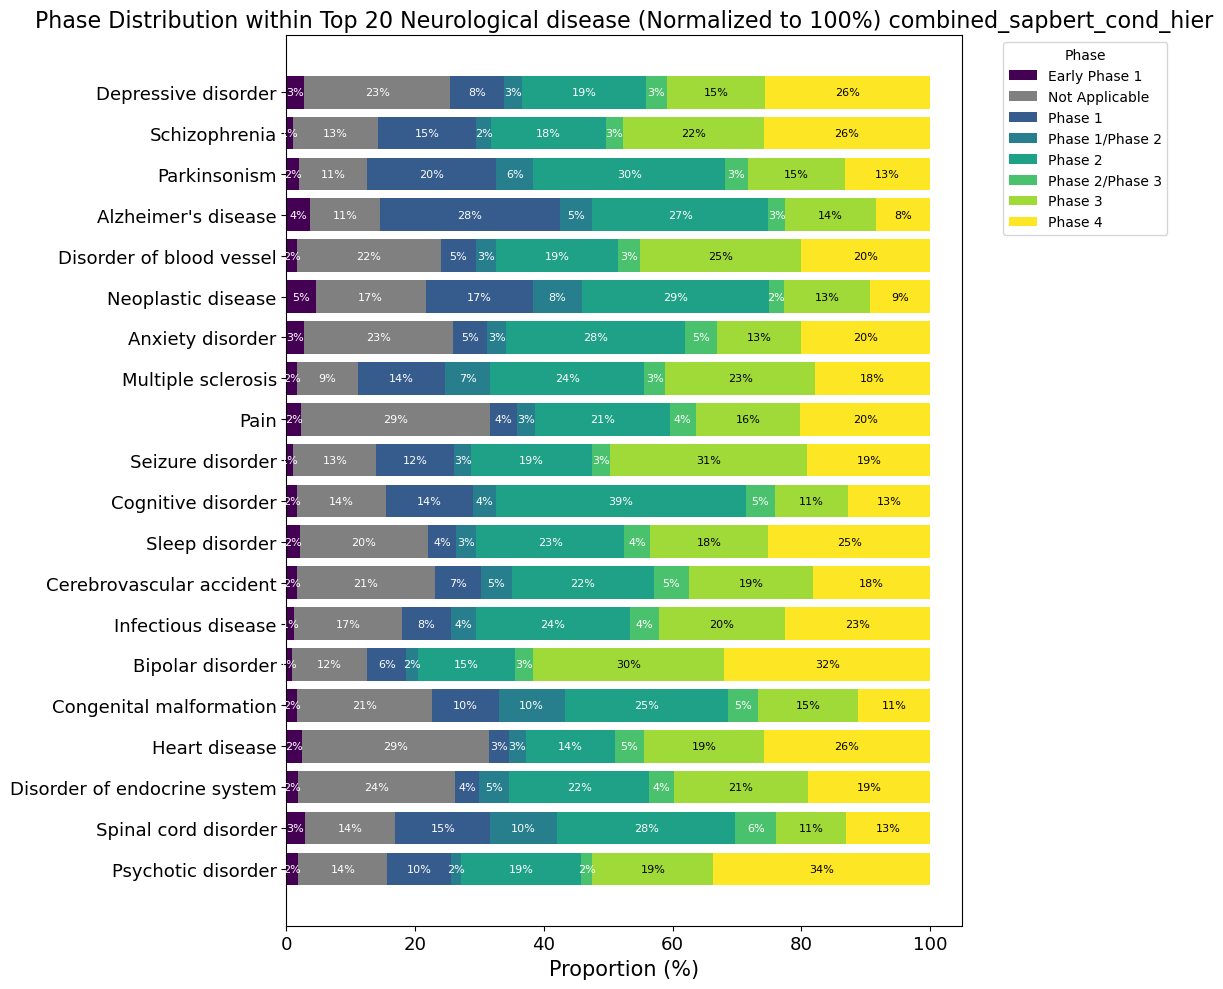

In [1073]:
plot_phase_distribution(aact_diseases, 'Neurological Disease', "disease", 'phase', 'nct_id', annotations_type, viz_path_diseases, top_n=20)


## Disease/ Time

In [1125]:
def plot_distribution_over_time(data, entity_column, entity_type, year_column, nct_id_column, annotations_type, viz_path, top_n=10):
    """
    Generates a line chart showing the distribution of top entities (e.g., diseases) over start years 
    and saves it to a specified path.

    Parameters:
    data (pd.DataFrame): The input dataframe containing entity, start year, and nct_id columns.
    entity_column (str): The column name in the dataframe representing the entities (e.g., diseases).
    year_column (str): The column name representing the start year of the trials.
    nct_id_column (str): The column name representing the unique trial IDs.
    annotations_type (str): A string to specify the type of annotations for the title and filename.
    viz_path (Path or str): The path where the plot image will be saved.
    top_n (int): The number of top entities to display in the chart. Default is 10.
    """
    # Step 1: Keeping only unique nct_id, entity pairs
    unique_pairs = data[[nct_id_column, entity_column]].drop_duplicates()
    
    # Step 2: Counting the number of nct_ids per entity type and selecting the top N
    entity_counts = unique_pairs[entity_column].value_counts().sort_values(ascending=False).head(top_n)
    
    # Step 3: Filter data to include only the top N entities
    data_top_entities = data[data[entity_column].isin(entity_counts.index)]
    data_top_entities = data_top_entities[[nct_id_column, entity_column, year_column]].drop_duplicates()
    
    # Step 4: Group by start year and entity, count occurrences, and unstack to pivot entities as columns
    grouped = data_top_entities.groupby([year_column, entity_column]).size().unstack(fill_value=0)
    
    # Step 5: Plot the line chart
    grouped.plot(kind='line', marker='o', figsize=(10, 6))
    
    # Set the title and labels
    plt.title(f'Unique trials for {entity_column.capitalize()} over Start Years {annotations_type}')
    plt.xlabel('Start Year', fontsize=15)
    #plt.ylabel('Trials Count', fontsize=15)

    # Adjusting the tick size
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Show the plot
    plt.legend(title=entity_column.capitalize())
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.tight_layout()
    
    plt.savefig(viz_path / f"{entity_type}_over_time_{annotations_type}.png")
    plt.show()

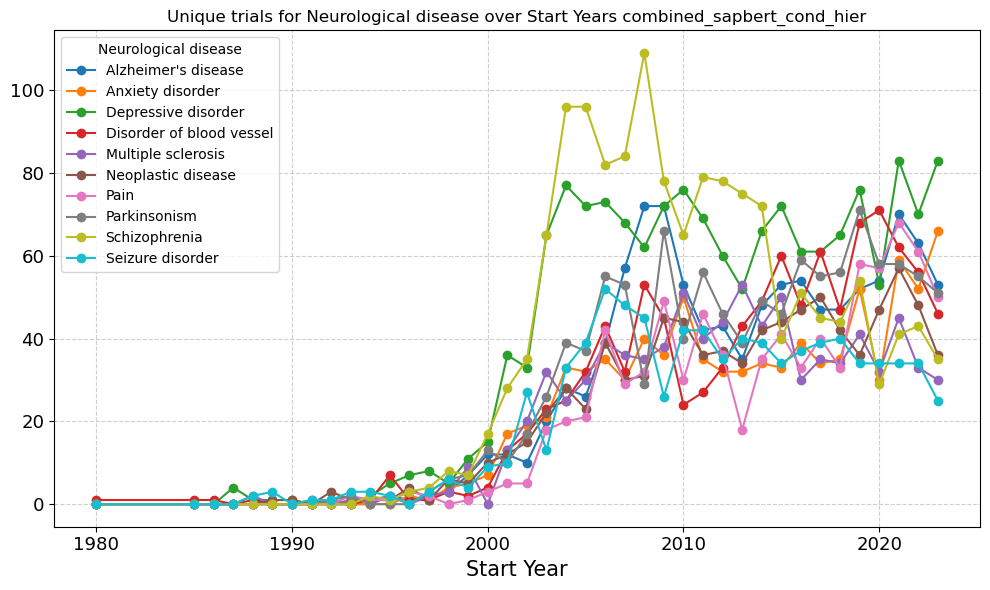

In [1126]:
plot_distribution_over_time(aact_diseases, 'Neurological Disease', 'disease', 'start_year', 'nct_id', annotations_type, viz_path_diseases, top_n=10)


In [1076]:
# Keeping only unique nct_id, phase pairs
unique_pairs = aact_diseases[['nct_id', 'Neurological Disease']].drop_duplicates()

# Counting the number of nct_ids per phase type
disease_counts = unique_pairs['Neurological Disease'].value_counts()
disease_counts = disease_counts.sort_values(ascending=False).head(10)
disease_counts

Neurological Disease
Depressive disorder         1566
Schizophrenia               1466
Parkinsonism                1103
Alzheimer's disease         1077
Disorder of blood vessel    1001
Neoplastic disease           879
Anxiety disorder             865
Multiple sclerosis           850
Pain                         840
Seizure disorder             839
Name: count, dtype: int64

# Interventions

In [1077]:
import textwrap


In [1078]:
viz_path_interventions = Path("viz/interventions/")

In [1079]:
aact_disease_intervention = reference_data[['nct_id', 'Neurological Disease', 'Disease Class', 'intervention_name', 'intervention_type', 'phase', 'overall_status', 'start_year']]

In [1080]:
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_type'] == 'Drug') | (aact_disease_intervention['intervention_type'] == 'Biological')]
#filtered_df = aact_disease_intervention[(aact_disease_intervention['intervention_name'] != 'Saline') & (aact_disease_intervention['intervention_type'] != 'Normal saline')]
#filtered_df.head(10)

In [1081]:
aact_disease_intervention['intervention_name'].isnull().sum()

/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


0

In [1082]:
aact_disease_intervention.dropna(subset=['intervention_name'], inplace=True)
aact_disease_intervention.drop(aact_disease_intervention[aact_disease_intervention['intervention_name'] == ''].index, inplace=True)

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1519962836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aact_disease_intervention.dropna(subset=['intervention_name'], inplace=True)
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/1519962836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aact_disease_intervention.drop(aact_disease_intervention[aact_disease_intervention['intervention_name'] == ''].index, inplace=True)


In [1083]:
aact_disease_intervention['intervention_name'].isnull().sum()

0

In [1084]:
len(set(reference_data['nct_id'])), len(set(aact_disease_intervention['nct_id']))

(19060, 19060)

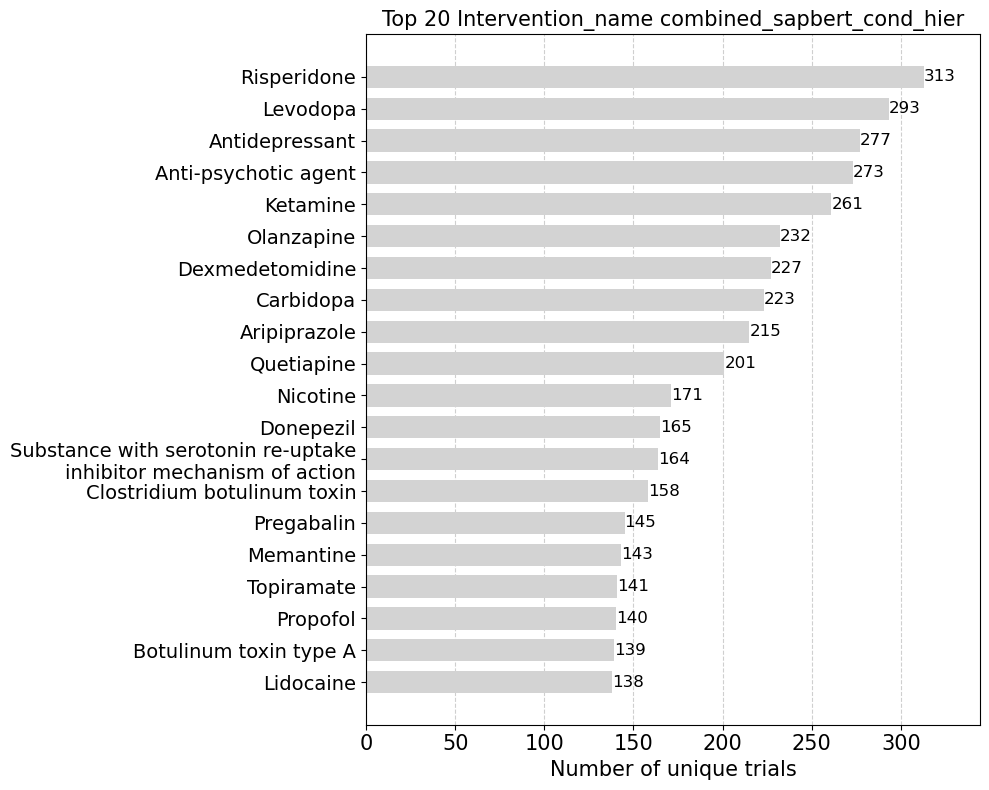

In [1085]:
plot_entity_frequency(aact_disease_intervention, 'intervention_name', 'interventions', annotations_type, viz_path_interventions, top_n=20)


In [1086]:
# Aggregate trials by disease and phase, counting unique nct_ids
intervention_phase_counts = aact_disease_intervention.groupby(['intervention_name', 'phase'])['nct_id'].nunique().reset_index()

#intervention_phase_counts_filtered = intervention_phase_counts[intervention_phase_counts['phase'] != 'Not Applicable']

# Pivot the filtered data to have interventions as rows and phases as columns
pivot_intervention_df_filtered = intervention_phase_counts.pivot(index='intervention_name', columns='phase', values='nct_id').fillna(0)

# Calculate total trials per intervention again without 'Not Applicable' phase
pivot_intervention_df_filtered['Total Trials'] = pivot_intervention_df_filtered.sum(axis=1)
top_interventions_filtered = pivot_intervention_df_filtered.sort_values('Total Trials', ascending=False).head(20)
top_interventions_filtered

phase,Early Phase 1,Not Applicable,Phase 1,Phase 1/Phase 2,Phase 2,Phase 2/Phase 3,Phase 3,Phase 4,Total Trials
intervention_name,,,,,,,,,
Risperidone,1.0,33.0,27.0,7.0,37.0,4.0,84.0,120.0,313.0
Levodopa,2.0,25.0,48.0,12.0,75.0,10.0,74.0,47.0,293.0
Antidepressant,3.0,80.0,14.0,7.0,36.0,10.0,36.0,91.0,277.0
Anti-psychotic agent,1.0,54.0,17.0,6.0,27.0,5.0,56.0,107.0,273.0
Ketamine,14.0,50.0,34.0,13.0,58.0,16.0,19.0,57.0,261.0
Olanzapine,1.0,31.0,7.0,3.0,25.0,1.0,68.0,96.0,232.0
Dexmedetomidine,7.0,70.0,6.0,6.0,17.0,8.0,22.0,91.0,227.0
Carbidopa,2.0,8.0,81.0,8.0,69.0,7.0,34.0,14.0,223.0
Aripiprazole,1.0,21.0,18.0,1.0,22.0,3.0,61.0,88.0,215.0


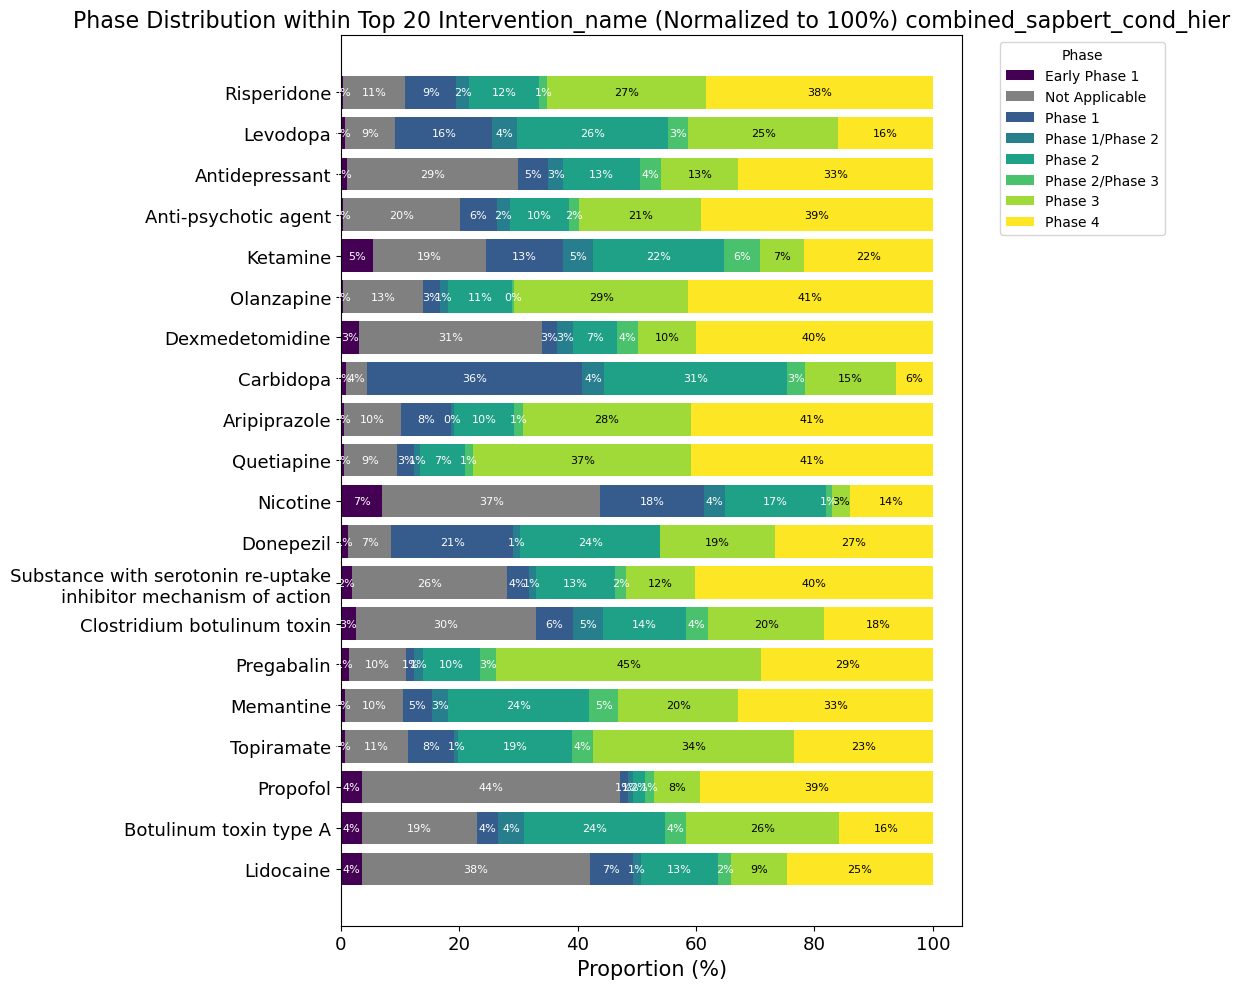

In [1087]:
plot_phase_distribution(aact_disease_intervention, 'intervention_name', 'interventions', 'phase', 'nct_id', annotations_type, viz_path_interventions, top_n=20)


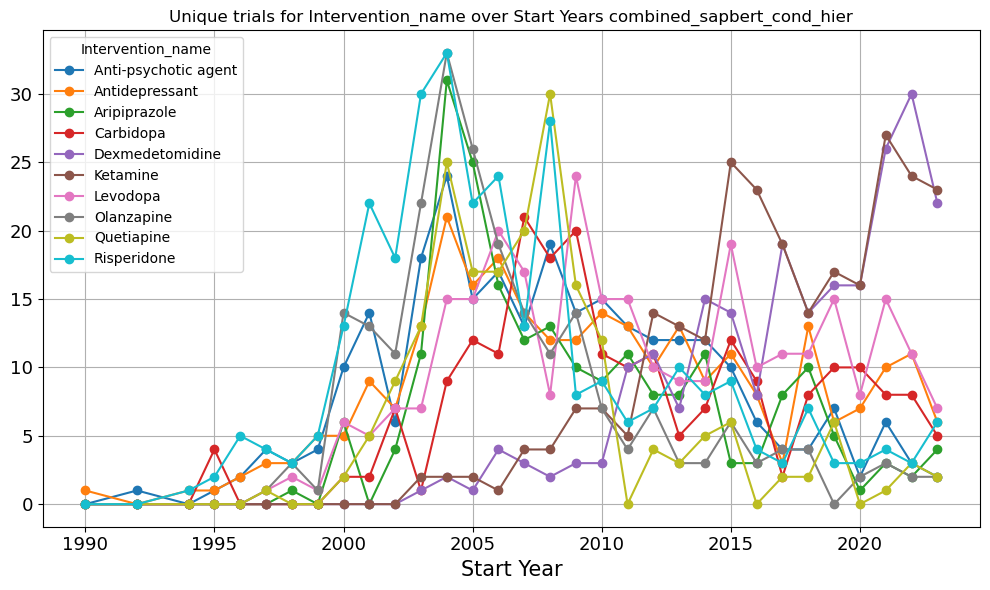

In [1088]:
plot_distribution_over_time(aact_disease_intervention,'intervention_name', 'interventions', 'start_year', 'nct_id', annotations_type, viz_path_interventions, top_n=10)


## Intervention/ Disease

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_72586/676463600.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_unique['disease_intervention_pair'] = filtered_df_unique['Neurological Disease'] + ' - ' + filtered_df_unique['intervention_name']


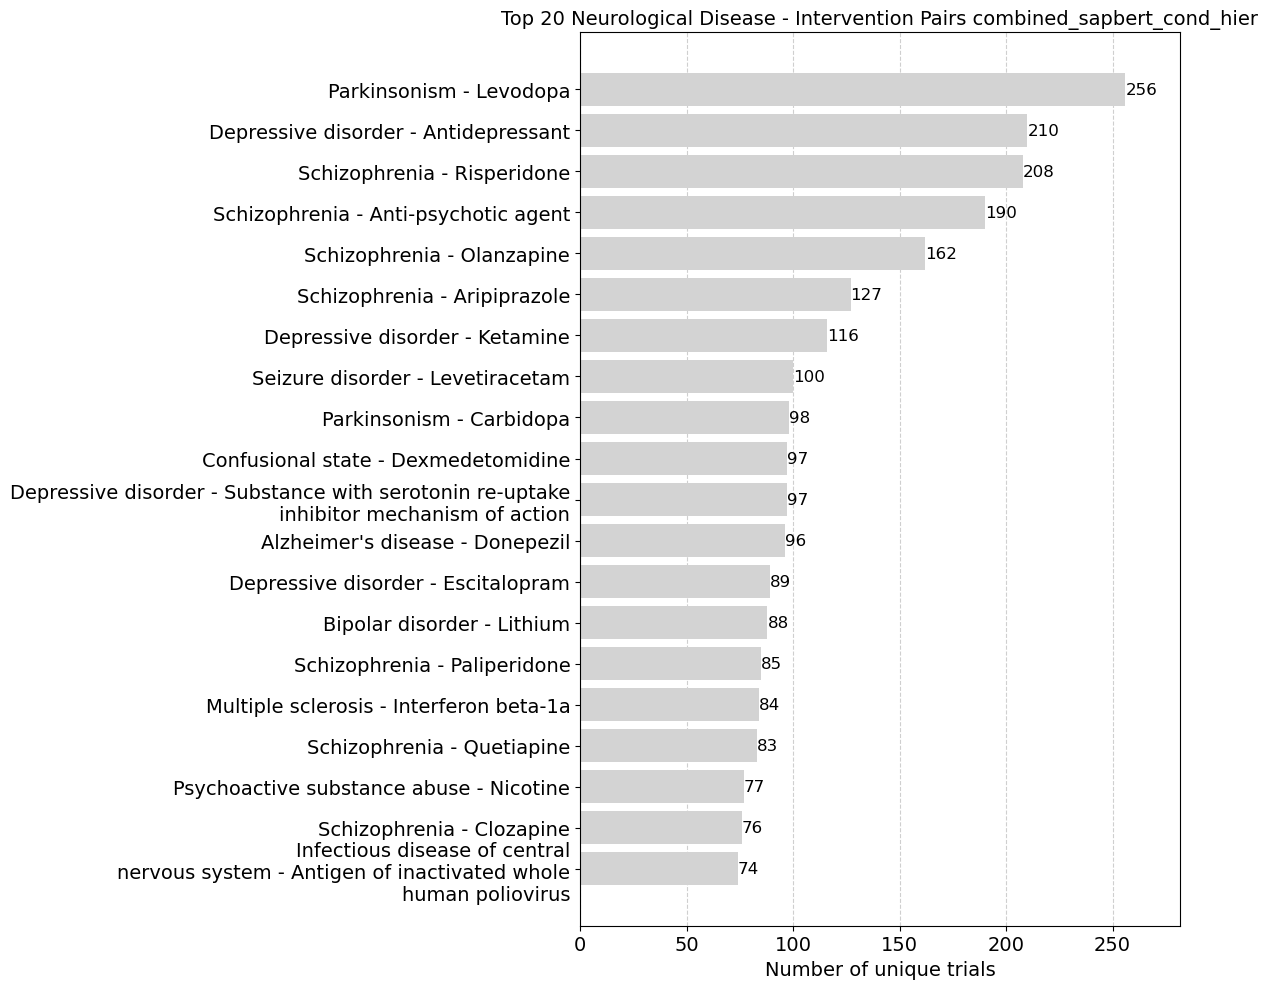

In [1091]:
filtered_df = aact_disease_intervention.copy()

# Normalize 'intervention_name' to start with a capital letter
filtered_df['intervention_name'] = filtered_df['intervention_name'].str.capitalize()

# Drop duplicates based on 'nct_id' to ensure uniqueness
filtered_df_unique = filtered_df.drop_duplicates(subset=['nct_id', 'Neurological Disease', 'intervention_name'])

# Create pairs of unique 'nct_id'
filtered_df_unique['disease_intervention_pair'] = filtered_df_unique['Neurological Disease'] + ' - ' + filtered_df_unique['intervention_name']

# Count the frequency of each unique pair
pair_counts_unique = filtered_df_unique['disease_intervention_pair'].value_counts()

# Select the top 20 most frequent pairs
top_20_pairs_unique = pair_counts_unique.head(20).sort_values(ascending=True)  # Sort ascending for plot layout

# Plot with specified formatting
plt.figure(figsize=(12, 10))
bars = plt.barh(top_20_pairs_unique.index, top_20_pairs_unique, color='lightgrey', zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Number of unique trials', fontsize=14)
plt.title(f'Top 20 Neurological Disease - Intervention Pairs {annotations_type}', fontsize=14)
plt.tight_layout()
plt.xlim(0, max(pair_counts_unique) + max(pair_counts_unique)/10)  # Adjusted to max count for relevancy

# Save the plot to a local folder
plt.savefig(f'viz/disease_intervention_pair_frequency_{annotations_type}.png')

plt.show()


In [1092]:
disease_intervenion_pairs = filtered_df_unique[['nct_id', 'disease_intervention_pair']].drop_duplicates()

In [1093]:
disease_intervenion_pairs.to_csv(f"./analysis/disease_intervenion_pairs_{annotations_type}.csv")


In [1116]:
aact_disease_intervention_with_entity_tags = reference_data_with_entity_tags[['nct_id', 'Neurological Disease', 'Disease Class', 'intervention_name', 'intervention_type', 'phase', 'overall_status', 'start_year']]
filtered_df = aact_disease_intervention_with_entity_tags.copy()

In [1119]:
# Step 1: Drop duplicates based on 'nct_id' and 'intervention_name'
unique_interventions_df = filtered_df[['nct_id', 'intervention_name', 'Neurological Disease']].drop_duplicates()

# Step 2: Identify the top 10 interventions
top_10_interventions = unique_interventions_df['intervention_name'].value_counts().head(10).index

# Step 3: Create the dictionary for top 10 interventions with unique diseases
intervention_diseases_dict = {}
for intervention in top_10_interventions:
    # Get the unique diseases tested for each intervention
    #unique_diseases = set(unique_interventions_df[unique_interventions_df['intervention_name'] == intervention]['Neurological Disease'])
    # Get the unique diseases tested for each intervention that contain "(disorder)" in the name
    unique_diseases = {
        disease for disease in unique_interventions_df[unique_interventions_df['intervention_name'] == intervention]['Neurological Disease']
        if isinstance(disease, str) and "(disorder)" in disease 
    }
    intervention_diseases_dict[intervention] = unique_diseases

intervention_diseases_dict['Ketamine (substance)']

{'Acute abdomen (disorder)',
 'Acute disease (disorder)',
 'Acute inflammatory disease (disorder)',
 'Adjustment disorder (disorder)',
 'Aneurysm (disorder)',
 'Anxiety disorder (disorder)',
 'Behavioral syndrome associated with\nphysiological disturbance and physical\nfactors (disorder)',
 'Benign intracranial hypertension (disorder)',
 'Bipolar disorder (disorder)',
 'Blood coagulation disorder (disorder)',
 'Bodily distress disorder (disorder)',
 'Burn (disorder)',
 'Cancer treatment related morbidity\n(disorder)',
 'Central pain syndrome (disorder)',
 'Cerebrovascular accident (disorder)',
 'Childhood and adolescent fearfulness\ndisturbance (disorder)',
 'Childhood or adolescent disorder\nof social functioning (disorder)',
 'Chronic disease (disorder)',
 'Chronic mental disorder (disorder)',
 'Chronic nervous system disorder\n(disorder)',
 'Chronic pain syndrome (disorder)',
 'Cognitive disorder (disorder)',
 'Communication disorder (disorder)',
 'Complication of anesthesia (disord

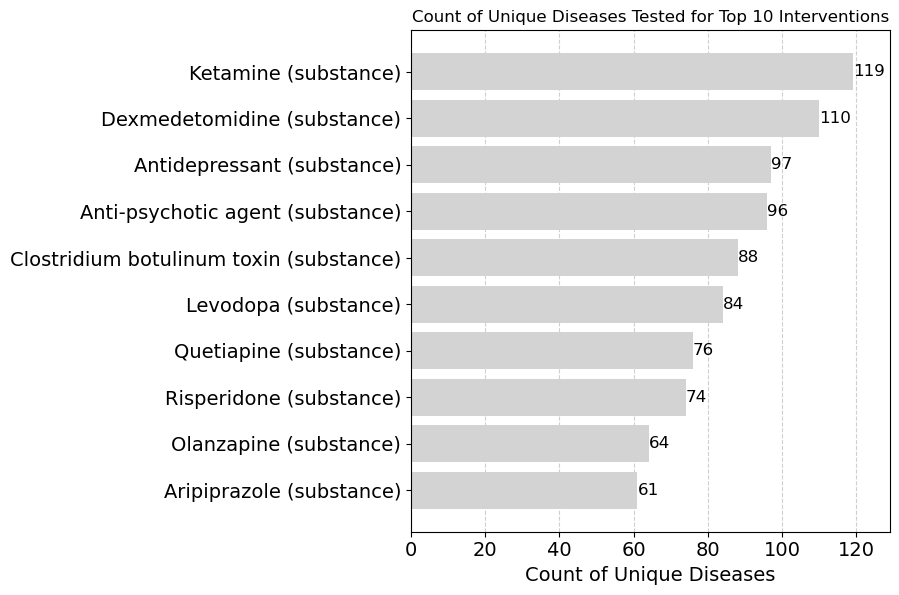

In [1120]:
# Calculate unique diseases count for each intervention
unique_diseases_counts = [len(diseases) for diseases in intervention_diseases_dict.values()]
# Extract the interventions list for ordering
interventions = list(intervention_diseases_dict.keys())

# Sort interventions by the count of unique diseases in descending order
sorted_indices = sorted(range(len(unique_diseases_counts)), key=lambda i: unique_diseases_counts[i], reverse=False)
sorted_interventions = [interventions[i] for i in sorted_indices]
sorted_unique_diseases_counts = [unique_diseases_counts[i] for i in sorted_indices]

# Plotting with sorted data
plt.figure(figsize=(8, 6))
bars = plt.barh(sorted_interventions, sorted_unique_diseases_counts, color='lightgrey', zorder=2)

# Add labels to each bar
for bar, count in zip(bars, sorted_unique_diseases_counts):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{count}', va='center', fontsize=12)

plt.xlabel('Count of Unique Diseases', fontsize=14)
#plt.ylabel('Intervention')
plt.title('Count of Unique Diseases Tested for Top 10 Interventions')
plt.tight_layout()
plt.xlim(0, max(sorted_unique_diseases_counts) + 10)  # Adjusted to max count for relevancy
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
# Include grid lines on the x-axis
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)

plt.show()


In [1121]:
interventions = list(intervention_diseases_dict.keys())
interventions

['Anti-psychotic agent (substance)',
 'Ketamine (substance)',
 'Risperidone (substance)',
 'Dexmedetomidine (substance)',
 'Levodopa (substance)',
 'Antidepressant (substance)',
 'Olanzapine (substance)',
 'Clostridium botulinum toxin (substance)',
 'Quetiapine (substance)',
 'Aripiprazole (substance)']

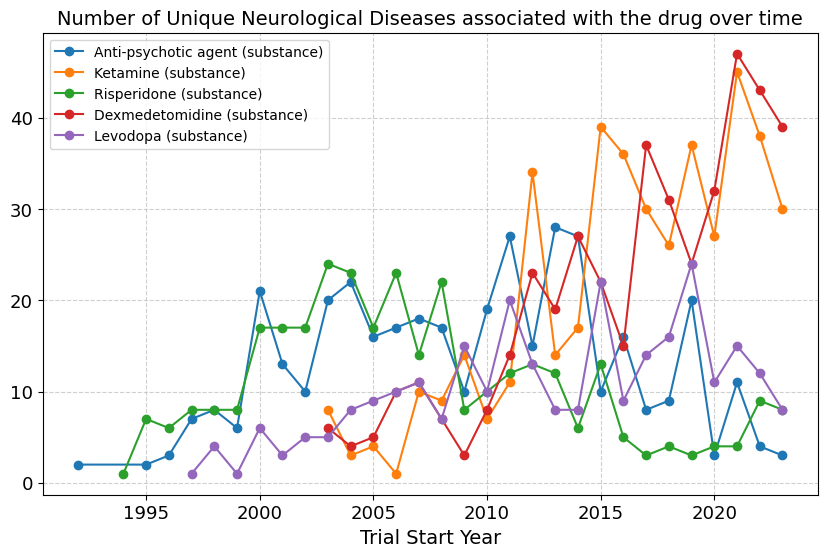

In [1128]:
# Function to get the unique diseases started in each year for given interventions
def get_unique_diseases_by_year(df, intervention):
    filtered_df = df[df['intervention_name'] == intervention]
    result = filtered_df.groupby('start_year')['Neurological Disease'].nunique().reset_index()
    result.columns = ['start_year', 'unique_disease_count']
    return result

# Function to plot the result
def plot_unique_diseases_over_time(df, interventions):
    plt.figure(figsize=(10, 6))
    for intervention in interventions:
        result_df = get_unique_diseases_by_year(df, intervention)
        plt.plot(result_df['start_year'], result_df['unique_disease_count'], marker='o', linestyle='-', label=intervention)
    plt.title('Number of Unique Neurological Diseases associated with the drug over time', fontsize=14)
    plt.xlabel('Trial Start Year', fontsize=14)
    #plt.ylabel('Unique Neurological Disease Count')
    plt.legend()
    plt.tick_params(axis='y', labelsize=13)
    plt.tick_params(axis='x', labelsize=13)
    plt.grid(linestyle='--', alpha=0.6, zorder=1)
    plt.show()

# Example usage
selected_interventions = ['Ketamine (substance)', 'Levodopa (substance)']
plot_unique_diseases_over_time(filtered_df, interventions[:5])


# Comparison aact vs bert

In [93]:
df = pd.read_excel("data/quality_checks/biolinkbert_annotations_sample2_50_reviewed.xlsx")

In [94]:
df.head()

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
2,NCT03945279,biib100,biib100,amyotrophic lateral sclerosis,amyotrophic lateral sclerosis,0,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN


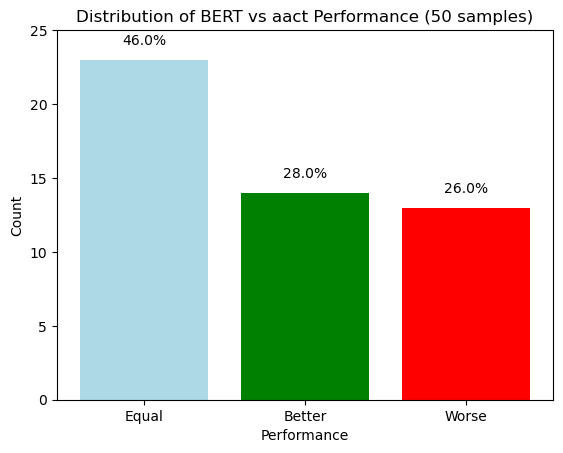

In [98]:
# Group by 'bert_performance' and count occurrences
performance_distribution = df['bert_performance (0: equal, 1: better, 2: worse)'].value_counts()

# Define labels for each category
labels = ['Equal', 'Better', 'Worse']

# Plot the bar chart
plt.bar(labels, performance_distribution, color=['lightblue', 'green', 'red'])

# Calculate the percentage of each category
total_count = performance_distribution.sum()
percentages = [count / total_count * 100 for count in performance_distribution]

# Annotate bars with percentages
for i, percentage in enumerate(percentages):
    plt.text(i, performance_distribution[i] + 1, f"{percentage:.1f}%", ha='center')
    
# Set the y-axis limit to reach 30
plt.ylim(0, 25)
# Set the title and labels
plt.title('Distribution of BERT vs aact Performance (50 samples)')
plt.xlabel('Performance')
plt.ylabel('Count')

plt.savefig("viz/bert_vs_aact_manual.png")
# Show the plot
plt.show()

### BERT advantages
- more details
- more specific
- easier to aggregate

In [96]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 1]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
0,NCT01942161,aripiprazole high (24 - 30 mg/day)|aripiprazol...,aripiprazole,schizophrenia,schizophrenia,1,NaN,NaN
3,NCT01137110,NaN,levetiracetam,subarachnoid hemorrhage,seizures|subarachnoid hemorrhage,1,NaN,NaN
4,NCT00004418,glyceryl trierucate/glyceryl trioleate,glyceryl trierucate|glyceryl trioleate|lorenzo...,adrenoleukodystrophy,adrenoleukodystrophy,1,NaN,NaN
5,NCT00829218,type: other,glutamate|msg,fibromyalgia|irritable bowel syndrome,fibromyalgia|ibs|irritable bowel syndrome,1,NaN,NaN
7,NCT00331825,risperidone and olanzapine,olanzapine|risperidone,extrapyramidal syndrome|schizophrenia,eps|neuroleptic-induced acute dystonia|parkins...,1,1.0,extrapyramidal syndrome not in the text
8,NCT03406702,cx-8998,cx-8998,epilepsy,absence seizures|idiopathic generalized epilepsy,1,1.0,only epilepsy missing in bert
10,NCT06100276,amt-162,amt-162|therapy,amyotrophic lateral sclerosis,rapidly progressive als|sod1 amyotrophic later...,1,1.0,abbreviations not well disambiguated
11,NCT00095524,aripiprazole,aripiprazole|olanzapine,schizoaffective disorder|psychotic disorders|b...,overweight|psychotic disorders|schizoaffective...,1,NaN,NaN
16,NCT01957774,thr-18,alteplase|thr-18|tissue plasminogen activator,stroke,acute ischemic stroke|ischemic strokes|stroke,1,NaN,NaN
27,NCT01883505,levodopa and carbidopa,carbidopa|ld|levodopa|nd0612,parkinson disease,- treated|motor fluctuations|parkinson disease,1,NaN,NaN


### Issues
- main issue: mentions available in other parts of the data, e.g. brief title, detailed trial description
- extractions noise

In [97]:
df[df['bert_performance (0: equal, 1: better, 2: worse)'] == 2]

,nct_id,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,"bert_performance (0: equal, 1: better, 2: worse)",tricky,comment
1,NCT02363517,sofosbuvir/ledispasvir fixed dose combination ...,ledipasvir|sofosbuvir,"substance abuse, intravenous|hepatitis c",hepatitis c virus,2,1.0,substance abuse indirectly implied
9,NCT00538642,ziprasidone,antipsychotics|ziprasidone,schizoaffective disorder|psychotic disorders|b...,bipolar disorder|diabetes|diabetic|pre-diabeti...,2,1.0,NaN
14,NCT03432871,type: dietary supplement,nicotinamide riboside,progressive external ophthalmoplegia|ophthalmo...,mitochondrial disease|mitochondrial disorders,2,1.0,ophthalmoplegia mentioned only in the detailed...
19,NCT00986115,memantine,memantine,epilepsy,alzheimer disease|epilepsy|seizures,2,1.0,alzheimer disease is a false positive
22,NCT01280006,celecoxib|indomethacin,NaN,stroke|hypertension|cardiovascular diseases|sl...,intermittent hypoxia,2,1.0,Arms and Interventions field of AACT? Missing ...
23,NCT02034474,tocilizumab,il-6 receptor antibody|tocilizumab,schizoaffective disorder|psychotic disorders|s...,"residual positive, negative, and cognitive sym...",2,NaN,NaN
25,NCT01069159,propranolol hydrochloride,propranolol,"stress disorders, post-traumatic|traumatic memory",propranolol treatment of traumatic memories|tr...,2,NaN,NaN
28,NCT00320723,"bupropion, transdermal nicotine patch",bupropion,schizoaffective disorder|psychotic disorders|s...,major mental illness|smoking,2,1.0,schizophrenia mentioned in brief title and det...
34,NCT00242177,actos (pioglitazone),NaN,"multiple sclerosis, relapsing-remitting","multiple sclerosis|multiple sclerosis, relapsi...",2,1.0,drug was mentioned in the detailed description
35,NCT01453127,i-123 ioflupane solution injection prior to sp...,NaN,rem sleep behavior disorder|dementia|parkinson...,alzheimer disease|dementia with lewy bodies|mi...,2,1.0,drug was mentioned in the detailed description


## disease-intervention pairs

In [99]:
if evaluate_snomed_link:
    suffix = "_sapbert"
else:
    suffix = ""

In [101]:
pairs_aact = pd.read_csv(f"./analysis/disease_intervenion_pairs_aact{suffix}.csv", index_col=0)
pairs_aact['disease_intervention_pair'] = pairs_aact['disease_intervention_pair'].str.lower()

pairs_bert = pd.read_csv(f"./analysis/disease_intervenion_pairs_biolinkbert{suffix}.csv", index_col=0)
pairs_bert['disease_intervention_pair'] = pairs_bert['disease_intervention_pair'].str.lower()


In [102]:
grouped_df_aact = pairs_aact.groupby('disease_intervention_pair').agg(
    nct_ids_aact=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_aact=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_aact = grouped_df_aact.sort_values(by='count_nct_ids_aact', ascending=False)
grouped_df_aact

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact
29111,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170
28919,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128
28545,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109
28943,schizophrenia - paliperidone palmitate,"[NCT00073320, NCT00077714, NCT00078039, NCT000...",83
7995,delirium - dexmedetomidine (substance),"[NCT00095251, NCT00351299, NCT00455143, NCT004...",82
...,...,...,...
12327,facioscapulohumeral muscular dystrophy (disord...,[NCT03123913],1
12326,facioscapulohumeral muscular dystrophy (disord...,[NCT00104078],1
12325,facioscapulohumeral muscular dystrophy (disord...,[NCT02948244],1
12324,facioscapulohumeral muscular dystrophy (disord...,[NCT01970735],1


In [103]:
grouped_df_bert = pairs_bert.groupby('disease_intervention_pair').agg(
    nct_ids_bert=('nct_id', list),              # Create a list of nct_ids
    count_nct_ids_bert=('nct_id', 'nunique')    # Count unique nct_ids
).reset_index()
grouped_df_bert = grouped_df_bert.sort_values(by='count_nct_ids_bert', ascending=False)


In [104]:
grouped_df_bert

,disease_intervention_pair,nct_ids_bert,count_nct_ids_bert
39041,schizophrenia - anti-psychotic agent (substance),"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261
32716,parkinson's disease - levodopa (substance),"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205
39435,schizophrenia - risperidone (substance),"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176
39343,schizophrenia - olanzapine (substance),"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134
41268,smoker - nicotine,"[NCT00108537, NCT00115687, NCT00135746, NCT001...",108
...,...,...,...
17360,frame-shift mutation - multiple of the median ...,[NCT00844597],1
17361,frame-shift mutation - naftifine hydrochloride,[NCT02500381],1
17362,frame-shift mutation - trvl 61866,[NCT00844597],1
17363,fraxinus americana specific diagnostic allerge...,[NCT00224640],1


In [105]:
# Merge the DataFrames on 'disease_intervention_pair'
merged_df = pd.merge(grouped_df_aact, grouped_df_bert, on='disease_intervention_pair', how='outer')

# Function to calculate intersections and differences
def calculate_overlaps(row):
    ids_a = set(row['nct_ids_aact']) if isinstance(row['nct_ids_aact'], list) else set()
    ids_b = set(row['nct_ids_bert']) if isinstance(row['nct_ids_bert'], list) else set()
    overlap = ids_a & ids_b
    unique_aact = ids_a - ids_b
    unique_bert = ids_b - ids_a
    return pd.Series({
        'overlap_count': len(overlap),
        'unique_aact_count': len(unique_aact),
        'unique_bert_count': len(unique_bert),
        'overlap_values': list(overlap),
        'unique_aact_values': list(unique_aact),
        'unique_bert_values': list(unique_bert)
    })

# Apply the function to each row
merged_df[['overlap_count', 'unique_aact_count', 'unique_bert_count', 
           'overlap_values', 'unique_aact_values', 'unique_bert_values']] = merged_df.apply(calculate_overlaps, axis=1)



In [106]:
merged_df.head(2)

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values
0,1011 - 1011,[NCT03829878],1.0,NaN,NaN,0,1,0,[],[NCT03829878],[]
1,115 - adult vaccine product containing only ac...,NaN,NaN,[NCT01642589],1.0,0,0,1,[],[],[NCT01642589]


In [107]:
merged_df['combined_frq'] = merged_df['overlap_count'] + merged_df['unique_aact_count'] + merged_df['unique_bert_count']
merged_df = merged_df.sort_values(by='combined_frq', ascending=False)


In [109]:
merged_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147


In [110]:
# Sorting the DataFrame by 'combined_frq' and selecting the top 20
top_df = merged_df.sort_values(by='combined_frq', ascending=False).head(20)

# Calculate proportions scaled to 100
top_df['total'] = top_df['overlap_count'] + top_df['unique_aact_count'] + top_df['unique_bert_count']
top_df['overlap_pct'] = (top_df['overlap_count'] / top_df['total']) * 100
top_df['unique_aact_pct'] = (top_df['unique_aact_count'] / top_df['total']) * 100
top_df['unique_bert_pct'] = (top_df['unique_bert_count'] / top_df['total']) * 100
top_df.head()

,disease_intervention_pair,nct_ids_aact,count_nct_ids_aact,nct_ids_bert,count_nct_ids_bert,overlap_count,unique_aact_count,unique_bert_count,overlap_values,unique_aact_values,unique_bert_values,combined_frq,total,overlap_pct,unique_aact_pct,unique_bert_pct
60470,schizophrenia - anti-psychotic agent (substance),"[NCT00931996, NCT01050582, NCT01192880, NCT013...",10.0,"[NCT00000371, NCT00001656, NCT00005658, NCT000...",261.0,5,5,256,"[NCT03548155, NCT02983188, NCT02360319, NCT020...","[NCT05039489, NCT00931996, NCT01050582, NCT011...","[NCT00538642, NCT00169026, NCT00757705, NCT021...",266,266,1.879699,1.879699,96.240602
61230,schizophrenia - risperidone (substance),"[NCT00000374, NCT00006195, NCT00014001, NCT000...",170.0,"[NCT00000267, NCT00006195, NCT00014001, NCT000...",176.0,95,75,81,"[NCT00526877, NCT00761670, NCT02019329, NCT001...","[NCT02051387, NCT00418873, NCT02650102, NCT021...","[NCT03237052, NCT00539071, NCT02765555, NCT008...",251,251,37.848606,29.880478,32.270916
50703,parkinson's disease - levodopa (substance),"[NCT00004733, NCT00096720, NCT00153972, NCT004...",26.0,"[NCT00004576, NCT00004733, NCT00006077, NCT000...",205.0,18,8,187,"[NCT01351168, NCT00153972, NCT00004733, NCT015...","[NCT03119636, NCT01770145, NCT01283594, NCT062...","[NCT03582371, NCT00462007, NCT02225548, NCT005...",213,213,8.450704,3.755869,87.793427
60989,schizophrenia - olanzapine (substance),"[NCT00000374, NCT00001656, NCT00006195, NCT000...",128.0,"[NCT00001656, NCT00006195, NCT00007774, NCT000...",134.0,77,51,57,"[NCT00485823, NCT00827918, NCT00169065, NCT002...","[NCT02051387, NCT02650102, NCT01129674, NCT001...","[NCT01420575, NCT02804568, NCT00078039, NCT000...",185,185,41.621622,27.567568,30.810811
60483,schizophrenia - aripiprazole (substance),"[NCT00036127, NCT00036361, NCT00044655, NCT000...",109.0,"[NCT00036361, NCT00088049, NCT00095524, NCT001...",99.0,61,48,38,"[NCT00737256, NCT00352339, NCT00392197, NCT013...","[NCT02650102, NCT01104766, NCT02054702, NCT011...","[NCT00325689, NCT03237052, NCT01742390, NCT038...",147,147,41.496599,32.653061,25.850340


In [111]:
top_df.to_csv(f"analysis/overlapping_unique_nct_ids{suffix}.csv")

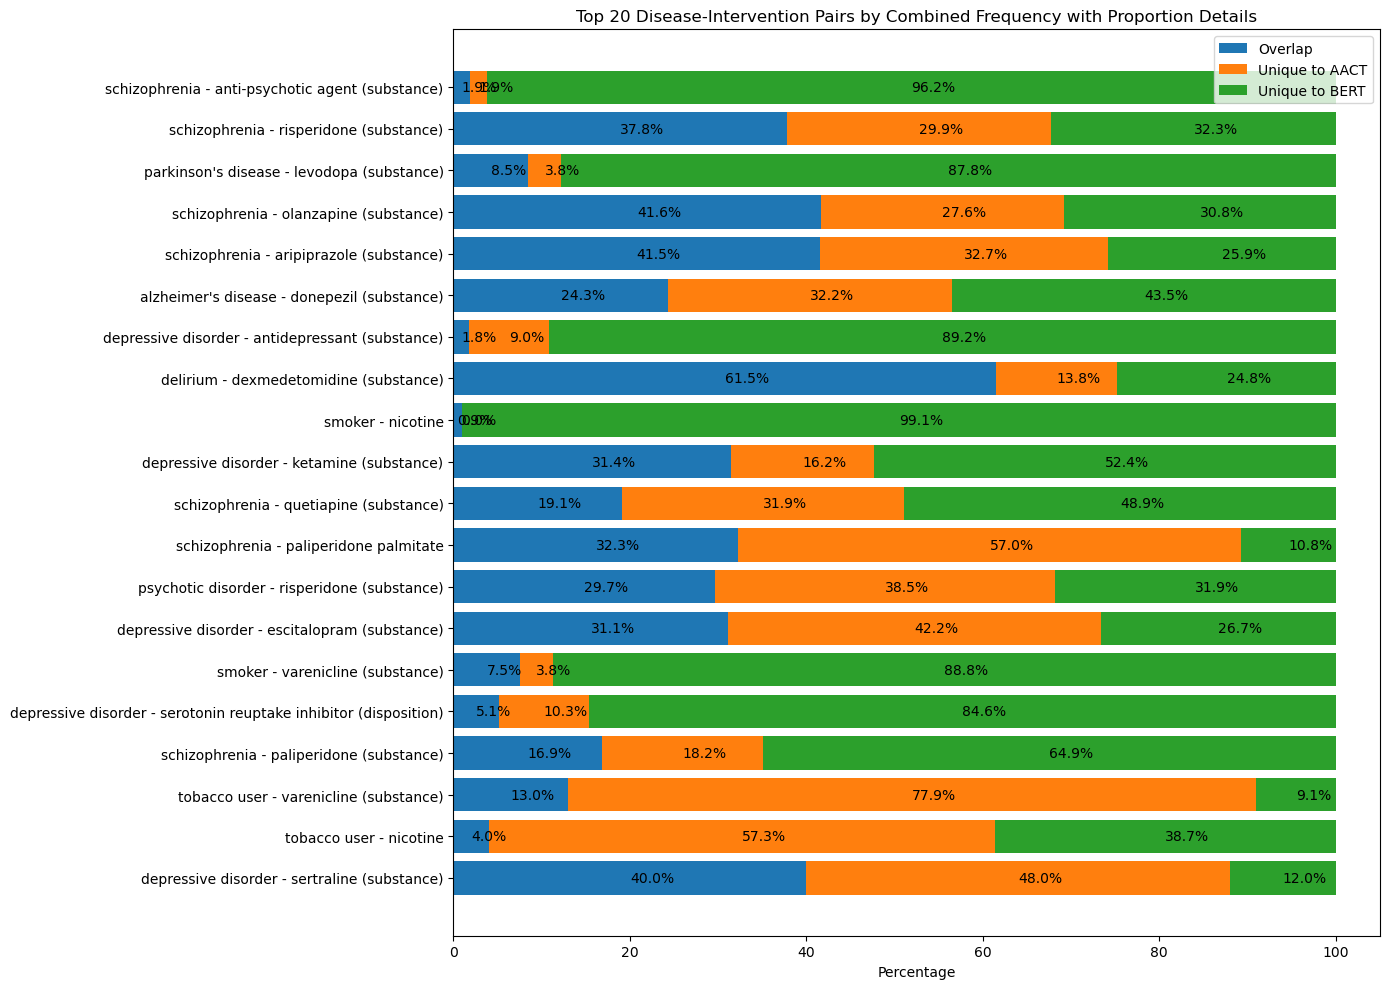

In [112]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define color scheme
bars_overlap = ax.barh(top_df['disease_intervention_pair'], top_df['overlap_pct'], color=colors[0], label='Overlap')
bars_unique_aact = ax.barh(top_df['disease_intervention_pair'], top_df['unique_aact_pct'], left=top_df['overlap_pct'], color=colors[1], label='Unique to AACT')
bars_unique_bert = ax.barh(top_df['disease_intervention_pair'], top_df['unique_bert_pct'], left=top_df['overlap_pct'] + top_df['unique_aact_pct'], color=colors[2], label='Unique to BERT')

# Add labels to the bars
def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        label_x_pos = bar.get_x() + width / 2
        ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', va='center')

add_labels(bars_overlap)
add_labels(bars_unique_aact)
add_labels(bars_unique_bert)

# Invert y-axis to have the first item at the top
ax.invert_yaxis()

ax.set_xlabel('Percentage')
ax.set_title('Top 20 Disease-Intervention Pairs by Combined Frequency with Proportion Details')
ax.set_yticks(range(len(top_df)))
ax.set_yticklabels(top_df['disease_intervention_pair'])
ax.legend()
plt.tight_layout()
plt.savefig(f'viz/bert_vs_aacts_drug_disease_pairs_nctids{suffix}.png')

plt.show()